# Reproject the ESA-CCI land cover map for Europe

This notebook demonstrates the use of the xcube.core.resampling.resample_in_space function to reproject the ESA-CCI Land Cover Map of Europe for the year 2022. The entire process is performed lazily and thus can be easily scaled up. 

In [1]:
from xcube.core.store import new_data_store
from xcube.core.resampling.reproject import reproject_dataset
from xcube.core.resampling import resample_in_space
from xcube.core.gridmapping import GridMapping
from datetime import datetime
import matplotlib.pyplot as plt
import pyproj
import numpy as np
import rioxarray

We use the land cover map stored in the [DeepESDL](https://www.earthsystemdatalab.net/) public S3 bucket. 

In [2]:
%%time
store = new_data_store("s3", root="deep-esdl-public")
mlds_lc = store.open_data("LC-1x2025x2025-2.0.0.levels")
ds = mlds_lc.base_dataset
ds

CPU times: user 196 ms, sys: 32.3 ms, total: 228 ms
Wall time: 1.01 s


<xarray.Dataset> Size: 3TB
Dimensions:              (time: 31, lat: 64800, lon: 129600, bounds: 2)
Coordinates:
  * lat                  (lat) float64 518kB 90.0 90.0 89.99 ... -90.0 -90.0
  * lon                  (lon) float64 1MB -180.0 -180.0 -180.0 ... 180.0 180.0
  * time                 (time) datetime64[ns] 248B 1992-01-01 ... 2022-01-01
Dimensions without coordinates: bounds
Data variables:
    change_count         (time, lat, lon) uint8 260GB dask.array<chunksize=(1, 2025, 2025), meta=np.ndarray>
    crs                  int32 4B ...
    current_pixel_state  (time, lat, lon) float32 1TB dask.array<chunksize=(1, 2025, 2025), meta=np.ndarray>
    lat_bounds           (lat, bounds) float64 1MB dask.array<chunksize=(2025, 2), meta=np.ndarray>
    lccs_class           (time, lat, lon) uint8 260GB dask.array<chunksize=(1, 2025, 2025), meta=np.ndarray>
    lon_bounds           (lon, bounds) float64 2MB dask.array<chunksize=(2025, 2), meta=np.ndarray>
    observation_count    (time, lat, lon) uint16 521GB dask.array<chunksize=(1, 2025, 2025), meta=np.ndarray>
    processed_flag       (time, lat, lon) float32 1TB dask.array<chunksize=(1, 2025, 2025), meta=np.ndarray>
    time_bounds          (time, bounds) datetime64[ns] 496B dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095451Z
    ...                         ...
    time_coverage_end:          19921231
    time_coverage_resolution:   P1Y
    time_coverage_start:        19920101
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                61b96fd7-42c3-4374-9de1-0dc3b0bcae2a
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y

We select the year and the spatial extend. 

In [3]:
%%time
ds = ds.sel(time=slice(datetime(2020, 1, 1), datetime(2022, 1, 1)))
ds = ds[["lccs_class"]]
ds

CPU times: user 65.7 ms, sys: 11.9 ms, total: 77.5 ms
Wall time: 75.9 ms


<xarray.Dataset> Size: 25GB
Dimensions:     (time: 3, lat: 64800, lon: 129600)
Coordinates:
  * lat         (lat) float64 518kB 90.0 90.0 89.99 89.99 ... -89.99 -90.0 -90.0
  * lon         (lon) float64 1MB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time        (time) datetime64[ns] 24B 2020-01-01 2021-01-01 2022-01-01
Data variables:
    lccs_class  (time, lat, lon) uint8 25GB dask.array<chunksize=(1, 2025, 2025), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095451Z
    ...                         ...
    time_coverage_end:          19921231
    time_coverage_resolution:   P1Y
    time_coverage_start:        19920101
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                61b96fd7-42c3-4374-9de1-0dc3b0bcae2a
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y

In [4]:
%%time
ds_clip = ds.sel(lon=slice(8, 13), lat=slice(54, 49))
ds_clip_large = ds.sel(lon=slice(0, 20), lat=slice(58, 45))

CPU times: user 7.75 ms, sys: 3.87 ms, total: 11.6 ms
Wall time: 10.2 ms


%%time
bbox = [8, 49, 13, 54]
target_crs = "EPSG:3035"
t = pyproj.Transformer.from_crs("EPSG:4326", target_crs, always_xy=True)
target_bbox = t.transform_bounds(*bbox)
spatial_res = 300
x_size = int((target_bbox[2] - target_bbox[0]) / spatial_res) + 1
y_size = int(abs(target_bbox[3] - target_bbox[1]) / spatial_res) + 1
target_gm = GridMapping.regular(
    size=(x_size, y_size),
    xy_min=(target_bbox[0] - spatial_res / 2, target_bbox[1] - spatial_res / 2),
    xy_res=spatial_res,
    crs=target_crs,
    tile_size=1000,
)

## Reprojection with rasterio

In [5]:
%%time
ds_clip = ds_clip.rio.write_crs("EPSG:4326")
ds_rioxarray = ds_clip.rio.reproject("EPSG:3035") 
ds_rioxarray

CPU times: user 778 ms, sys: 152 ms, total: 929 ms
Wall time: 3.06 s


<xarray.Dataset> Size: 9MB
Dimensions:      (x: 1421, y: 2177, time: 3)
Coordinates:
  * x            (x) float64 11kB 4.175e+06 4.175e+06 ... 4.54e+06 4.54e+06
  * y            (y) float64 17kB 3.437e+06 3.436e+06 ... 2.877e+06 2.876e+06
  * time         (time) datetime64[ns] 24B 2020-01-01 2021-01-01 2022-01-01
    spatial_ref  int64 8B 0
Data variables:
    lccs_class   (time, y, x) uint8 9MB 255 255 255 255 255 ... 255 255 255 255
Attributes: (12/38)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095451Z
    ...                         ...
    time_coverage_end:          19921231
    time_coverage_resolution:   P1Y
    time_coverage_start:        19920101
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                61b96fd7-42c3-4374-9de1-0dc3b0bcae2a
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y

/home/konstantin/micromamba/envs/xcube/lib/python3.13/site-packages/numpy/_core/numeric.py:366: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/home/konstantin/micromamba/envs/xcube/lib/python3.13/site-packages/numpy/_core/numeric.py:366: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


In [6]:
%%time
target_gm = GridMapping.from_dataset(ds_rioxarray, tile_size=1000)
target_gm

CPU times: user 18.1 ms, sys: 1.02 ms, total: 19.2 ms
Wall time: 18.2 ms


class: **RegularGridMapping**
* is_regular: True
* is_j_axis_up: False
* is_lon_360: _unknown_
* crs: PROJCS["ETRS89-extended / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Northing",NORTH],AXIS["Easting",EAST],AUTHORITY["EPSG","3035"]]
* xy_res: (257.4275, 257.4275)
* xy_bbox: (4174635, 2876214, 4540440, 3436633)
* ij_bbox: (0, 0, 1421, 2177)
* xy_dim_names: ('x', 'y')
* xy_var_names: ('x', 'y')
* size: (1421, 2177)
* tile_size: (1000, 1000)

## New reprojection method 

In [7]:
%%time
ds_reproject = reproject_dataset(ds, target_gm=target_gm)
ds_reproject

CPU times: user 160 ms, sys: 10.9 ms, total: 171 ms
Wall time: 170 ms


<xarray.Dataset> Size: 9MB
Dimensions:      (time: 3, x: 1421, y: 2177)
Coordinates:
  * time         (time) datetime64[ns] 24B 2020-01-01 2021-01-01 2022-01-01
  * x            (x) float64 11kB 4.175e+06 4.175e+06 ... 4.54e+06 4.54e+06
    spatial_ref  int64 8B 0
  * y            (y) float64 17kB 3.437e+06 3.436e+06 ... 2.877e+06 2.876e+06
Data variables:
    lccs_class   (time, y, x) uint8 9MB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095451Z
    ...                         ...
    time_coverage_end:          19921231
    time_coverage_resolution:   P1Y
    time_coverage_start:        19920101
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                61b96fd7-42c3-4374-9de1-0dc3b0bcae2a
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y

CPU times: user 1.53 s, sys: 233 ms, total: 1.76 s
Wall time: 2.93 s


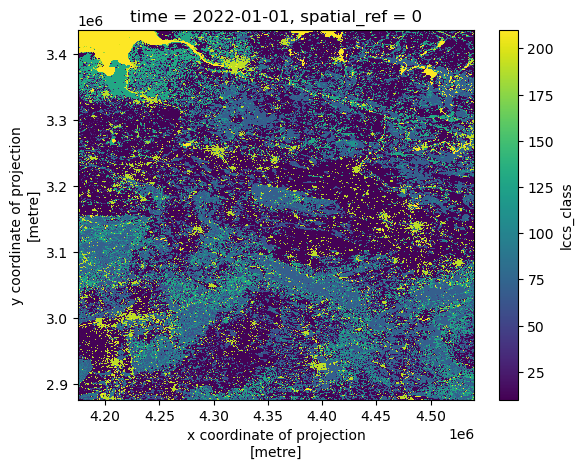

In [8]:
%%time
ds_reproject.lccs_class.isel(time=-1).plot()

## Old reprojection method via rectify_dataset

In [9]:
%%time
ds_resampling = resample_in_space(ds_clip_large, target_gm=target_gm)
ds_resampling

CPU times: user 39.1 s, sys: 6.91 s, total: 46.1 s
Wall time: 14.5 s


<xarray.Dataset> Size: 9MB
Dimensions:     (time: 3, y: 2177, x: 1421, bnds: 2)
Coordinates:
  * time        (time) datetime64[ns] 24B 2020-01-01 2021-01-01 2022-01-01
  * y           (y) float64 17kB 3.437e+06 3.436e+06 ... 2.877e+06 2.876e+06
  * x           (x) float64 11kB 4.175e+06 4.175e+06 ... 4.54e+06 4.54e+06
    x_bnds      (x, bnds) float64 23kB 4.175e+06 4.175e+06 ... 4.54e+06 4.54e+06
    y_bnds      (y, bnds) float64 35kB 3.437e+06 3.436e+06 ... 2.876e+06
Dimensions without coordinates: bnds
Data variables:
    lccs_class  (time, y, x) uint8 9MB dask.array<chunksize=(3, 1000, 1000), meta=np.ndarray>
    crs         int64 8B 0
Attributes: (12/38)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095451Z
    ...                         ...
    time_coverage_end:          19921231
    time_coverage_resolution:   P1Y
    time_coverage_start:        19920101
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                61b96fd7-42c3-4374-9de1-0dc3b0bcae2a
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y

CPU times: user 15.9 s, sys: 4.07 s, total: 20 s
Wall time: 4.08 s


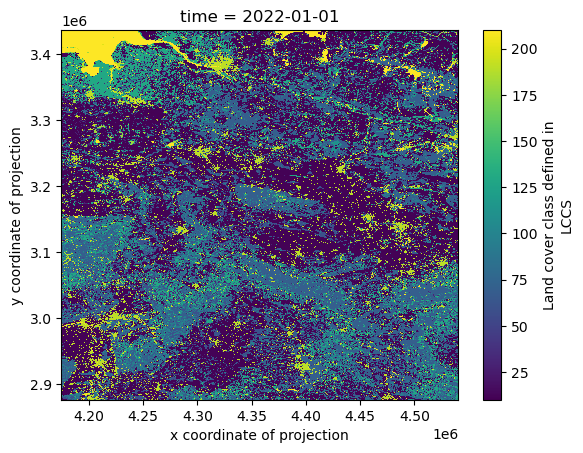

In [10]:
%%time
ds_resampling.lccs_class.isel(time=-1).plot()

## Difference

In [11]:
ds_resampling.lccs_class.isel(time=-1)


<xarray.DataArray 'lccs_class' (y: 2177, x: 1421)> Size: 3MB
dask.array<getitem, shape=(2177, 1421), dtype=uint8, chunksize=(1000, 1000), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 8B 2022-01-01
  * y        (y) float64 17kB 3.437e+06 3.436e+06 ... 2.877e+06 2.876e+06
  * x        (x) float64 11kB 4.175e+06 4.175e+06 ... 4.54e+06 4.54e+06
Attributes:
    ancillary_variables:  processed_flag current_pixel_state observation_coun...
    flag_colors:          #ffff64 #ffff64 #ffff00 #aaf0f0 #dcf064 #c8c864 #00...
    flag_meanings:        no_data cropland_rainfed cropland_rainfed_herbaceou...
    flag_values:          [0, 10, 11, 12, 20, 30, 40, 50, 60, 61, 62, 70, 71,...
    long_name:            Land cover class defined in LCCS
    standard_name:        land_cover_lccs
    valid_max:            220
    valid_min:            1
    grid_mapping:         crs

In [12]:
ds_reproject.lccs_class.isel(time=-1)


<xarray.DataArray 'lccs_class' (y: 2177, x: 1421)> Size: 3MB
dask.array<getitem, shape=(2177, 1421), dtype=uint8, chunksize=(1000, 1000), chunktype=numpy.ndarray>
Coordinates:
    time         datetime64[ns] 8B 2022-01-01
  * x            (x) float64 11kB 4.175e+06 4.175e+06 ... 4.54e+06 4.54e+06
    spatial_ref  int64 8B 0
  * y            (y) float64 17kB 3.437e+06 3.436e+06 ... 2.877e+06 2.876e+06

In [13]:
%%time 
diff = ds_resampling.lccs_class.isel(time=-1) - ds_reproject.lccs_class.isel(time=-1)
diff = diff.where(diff != 0, np.nan)
diff.plot()

TypeError: No numeric data to plot.

CPU times: user 1.55 s, sys: 124 ms, total: 1.67 s
Wall time: 3.44 s


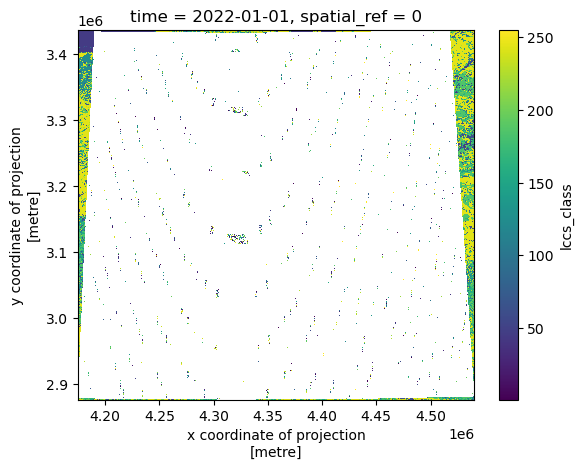

In [14]:
%%time
diff = ds_rioxarray.lccs_class.isel(time=-1) - ds_reproject.lccs_class.isel(time=-1)
diff = diff.where(diff != 0, np.nan)
diff.plot()